In [1]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects_new/TEST_AAS/TEST/AAS-18-290_6DOF_manuscript/Run/Run_4km_terminal


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


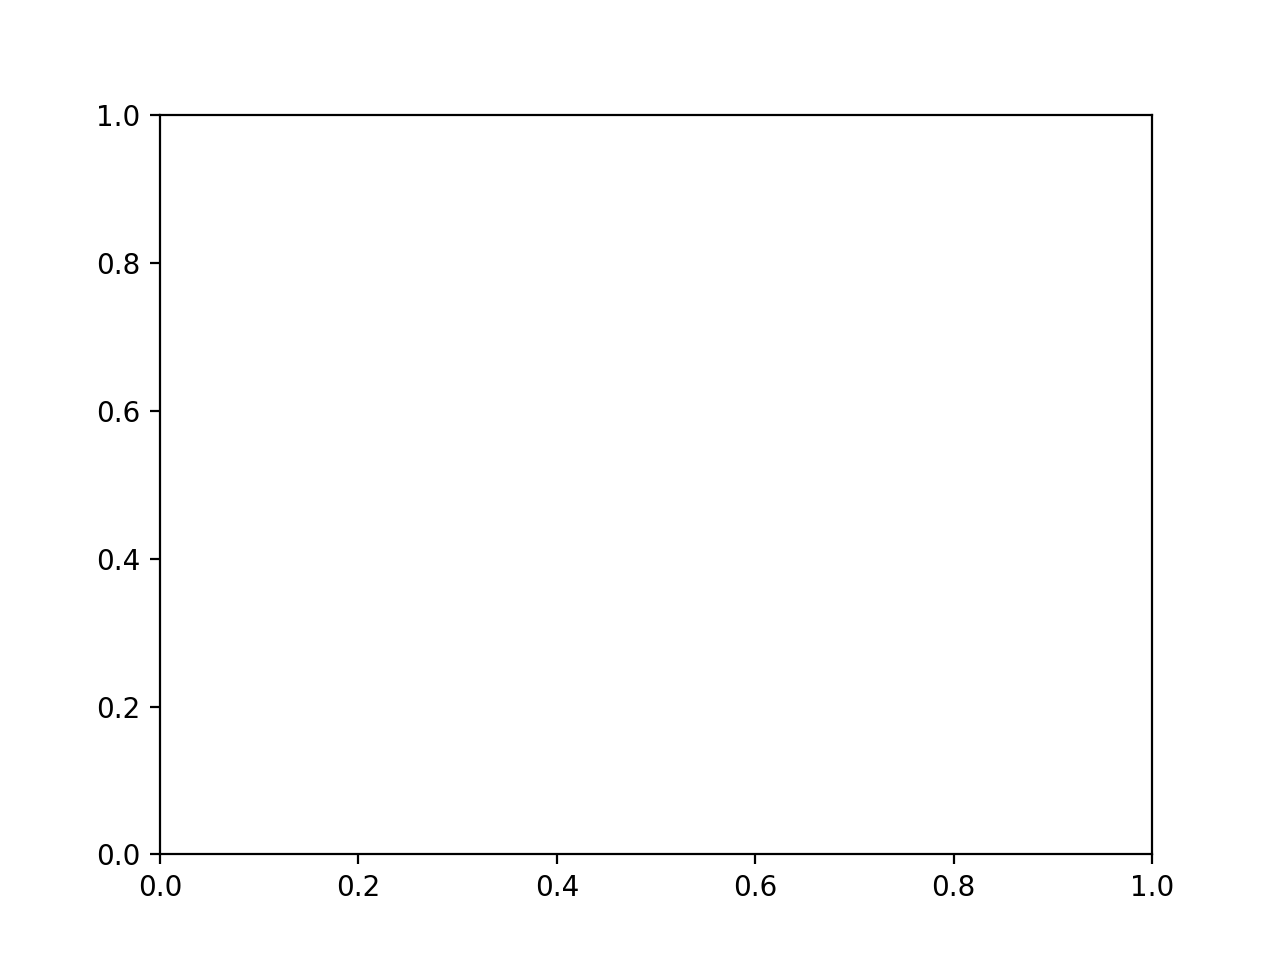

<IPython.core.display.Javascript object>


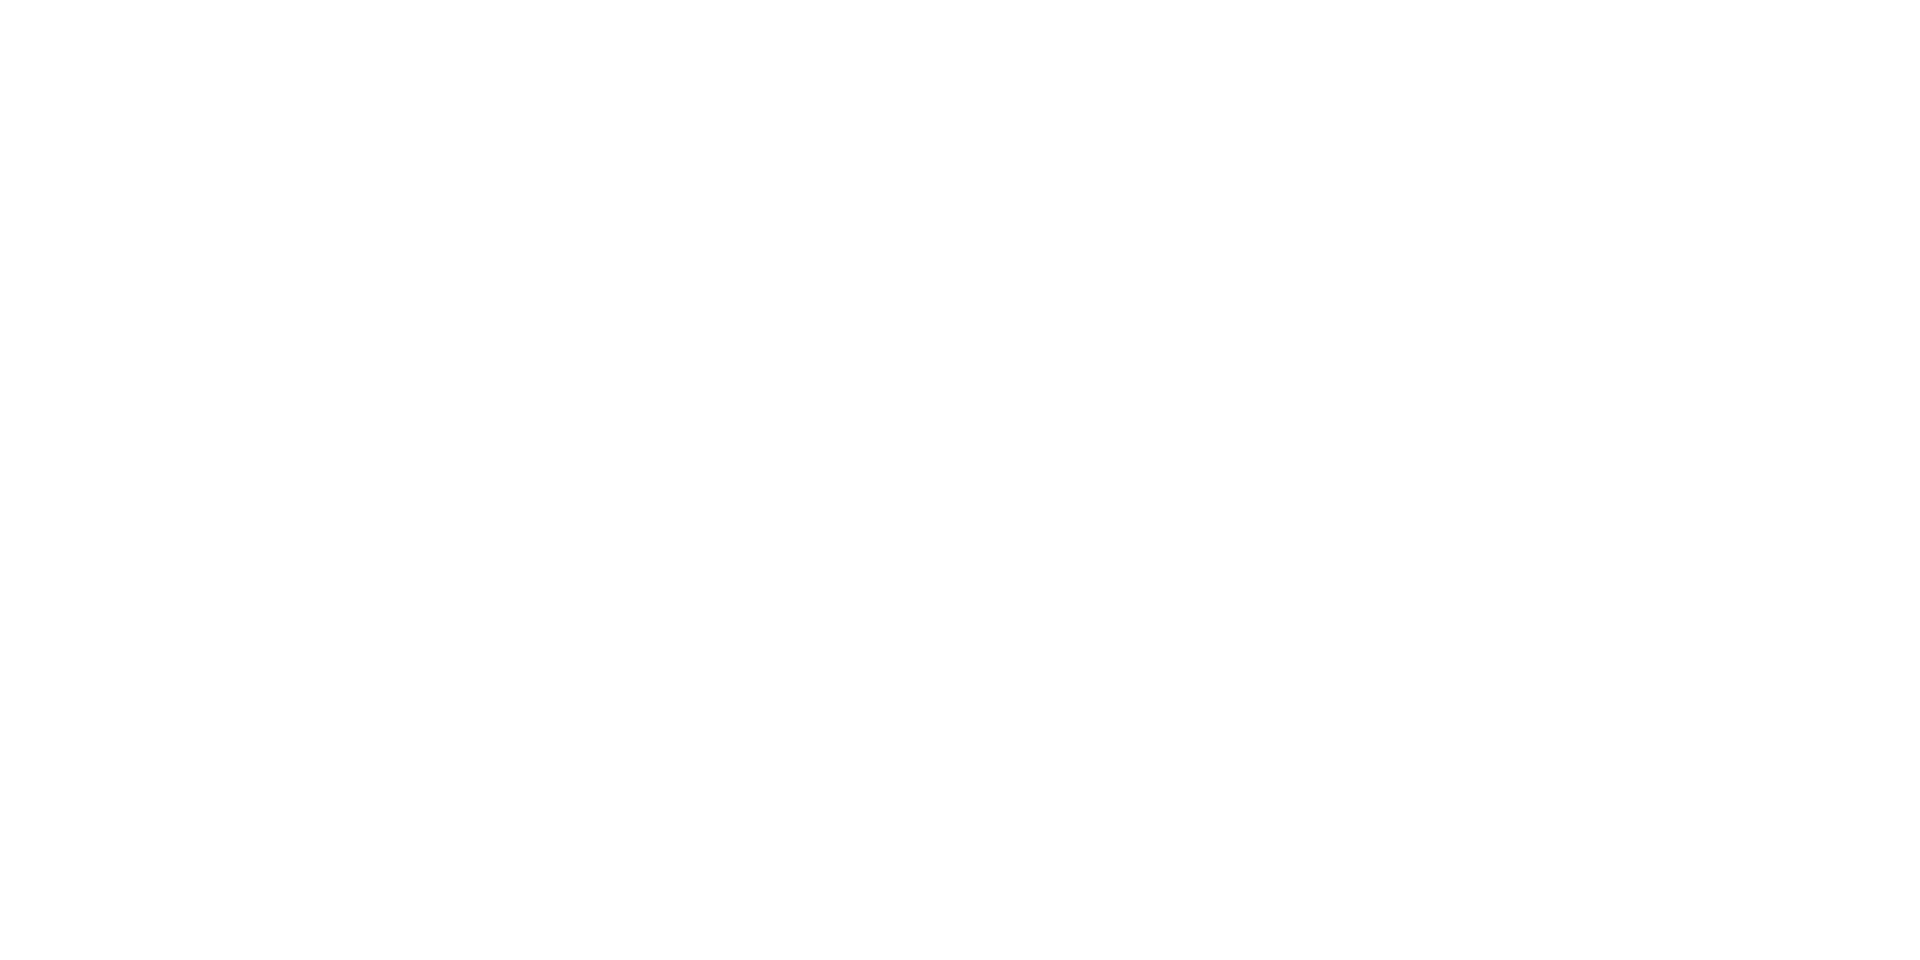

<IPython.core.display.Javascript object>


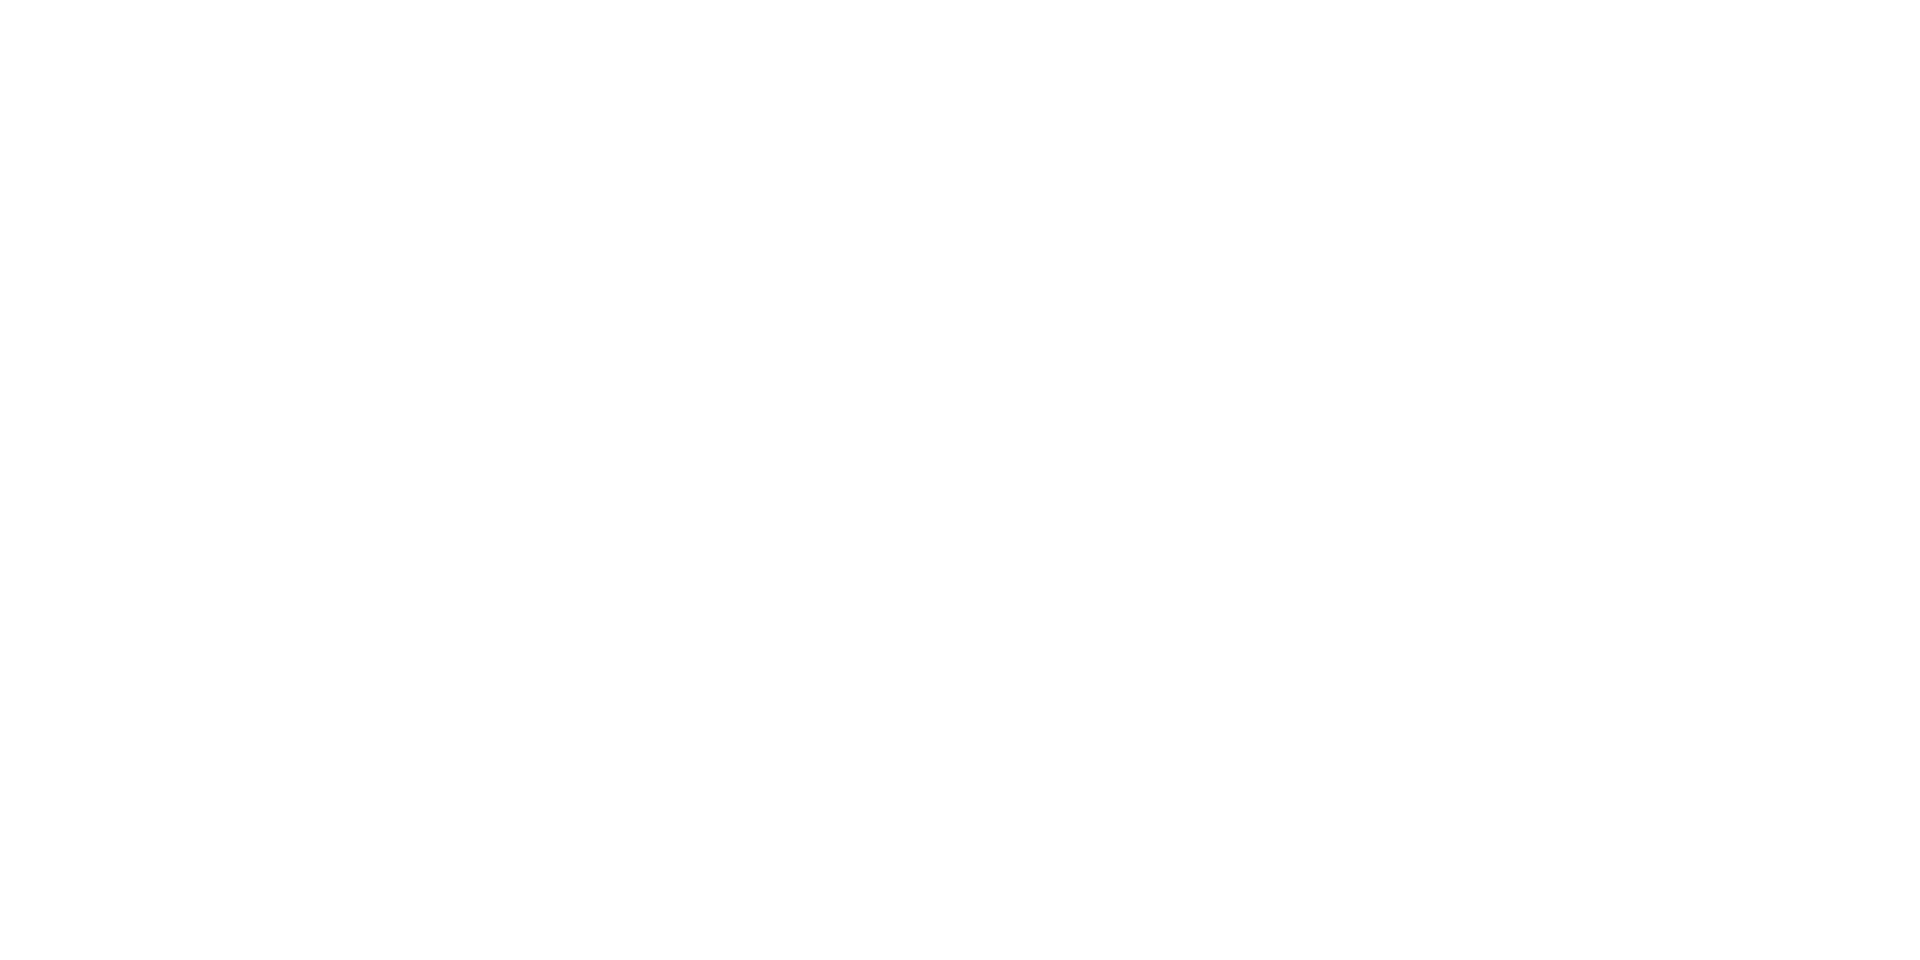

<IPython.core.display.Javascript object>


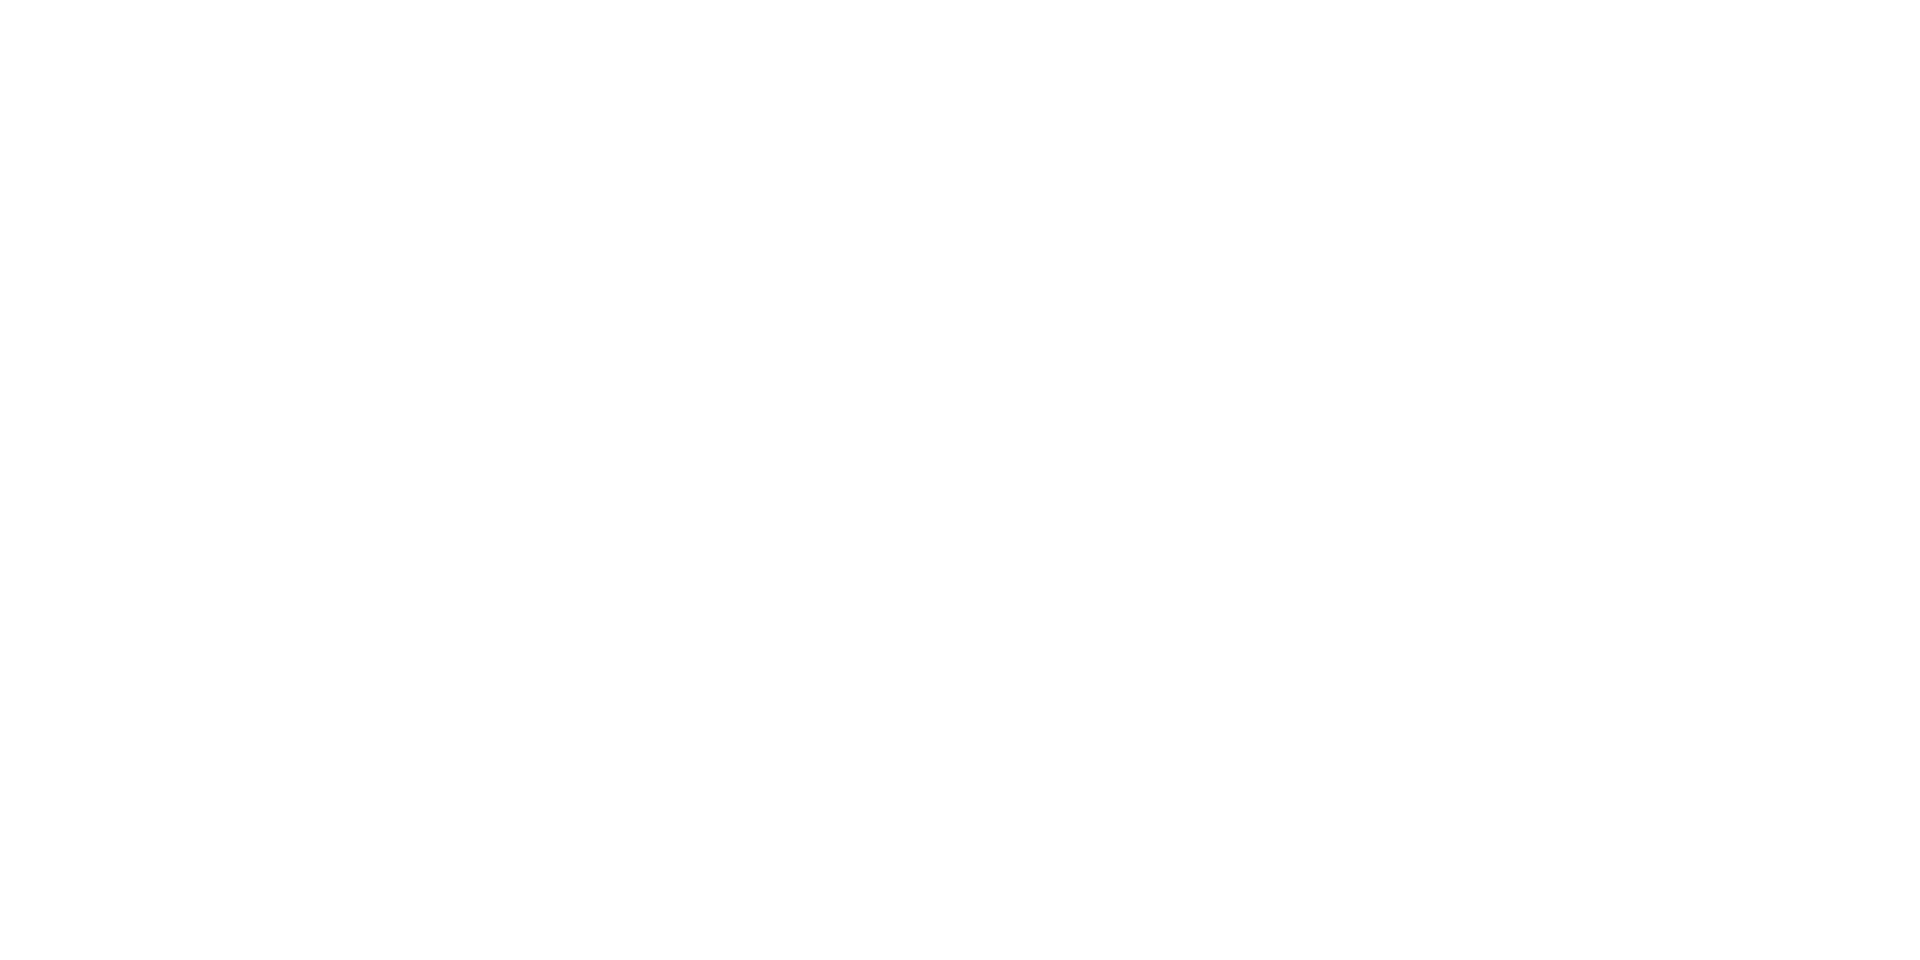

<IPython.core.display.Javascript object>


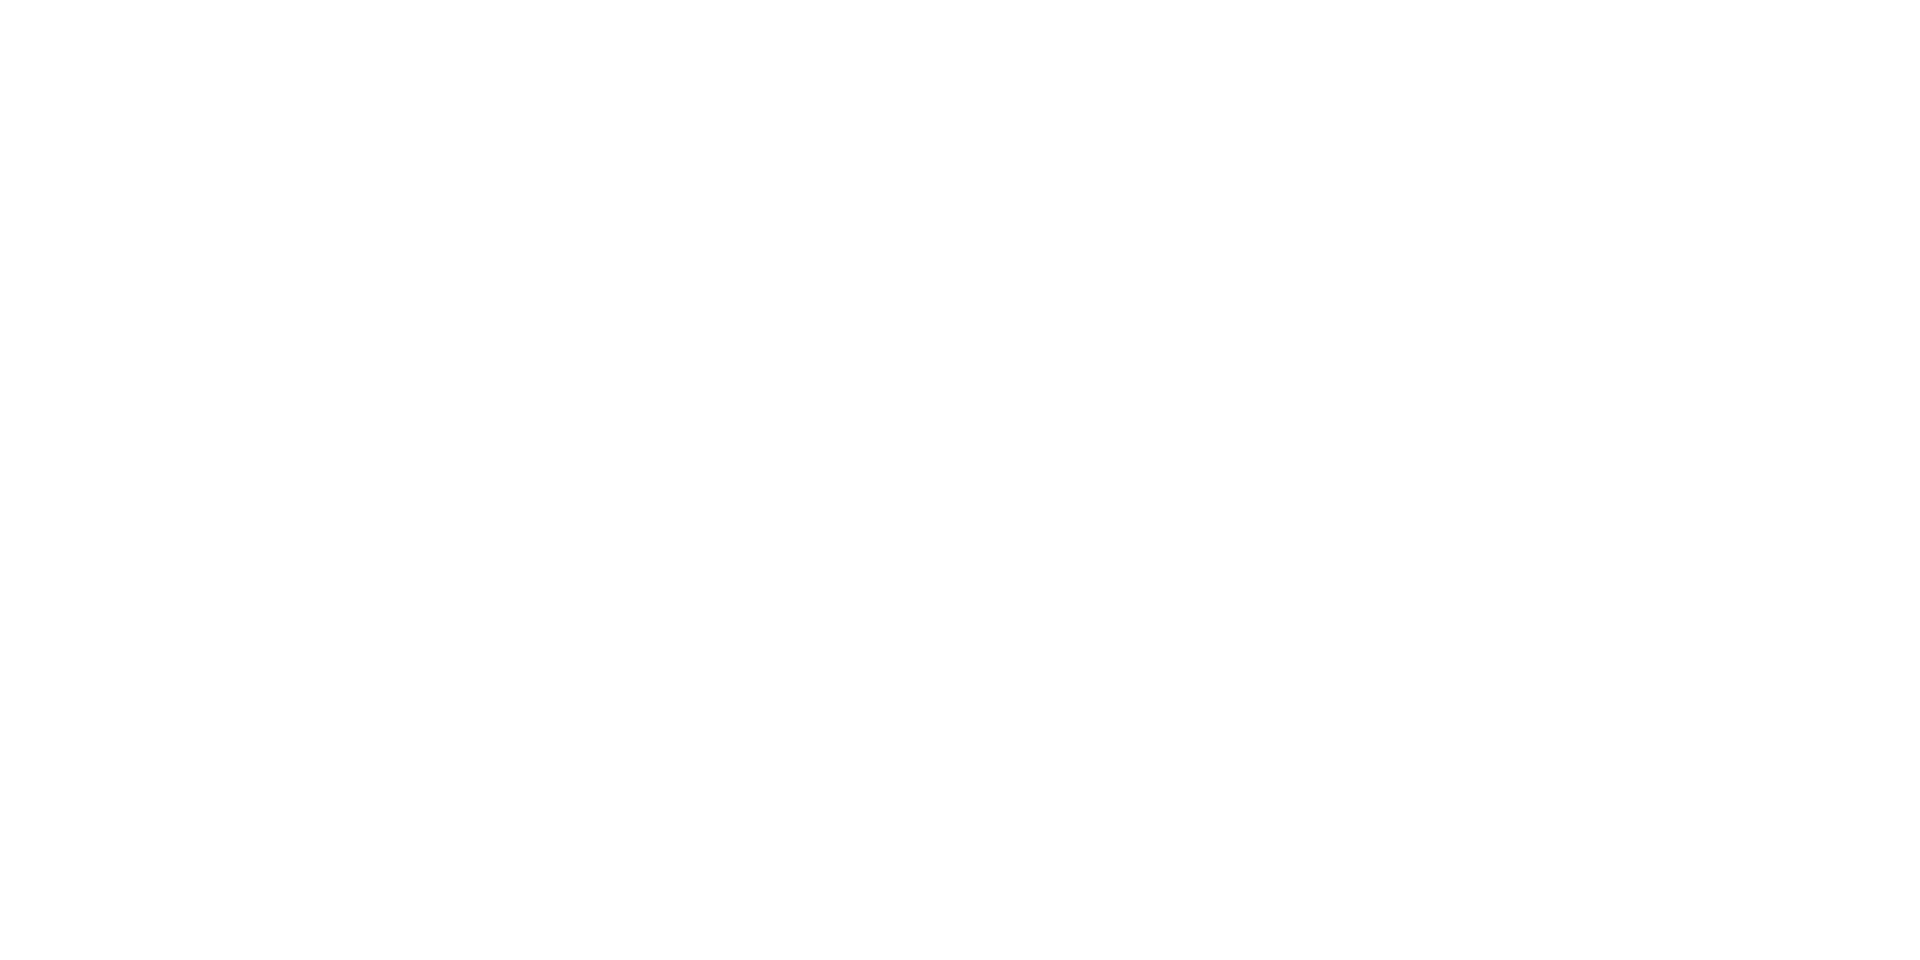

<IPython.core.display.Javascript object>


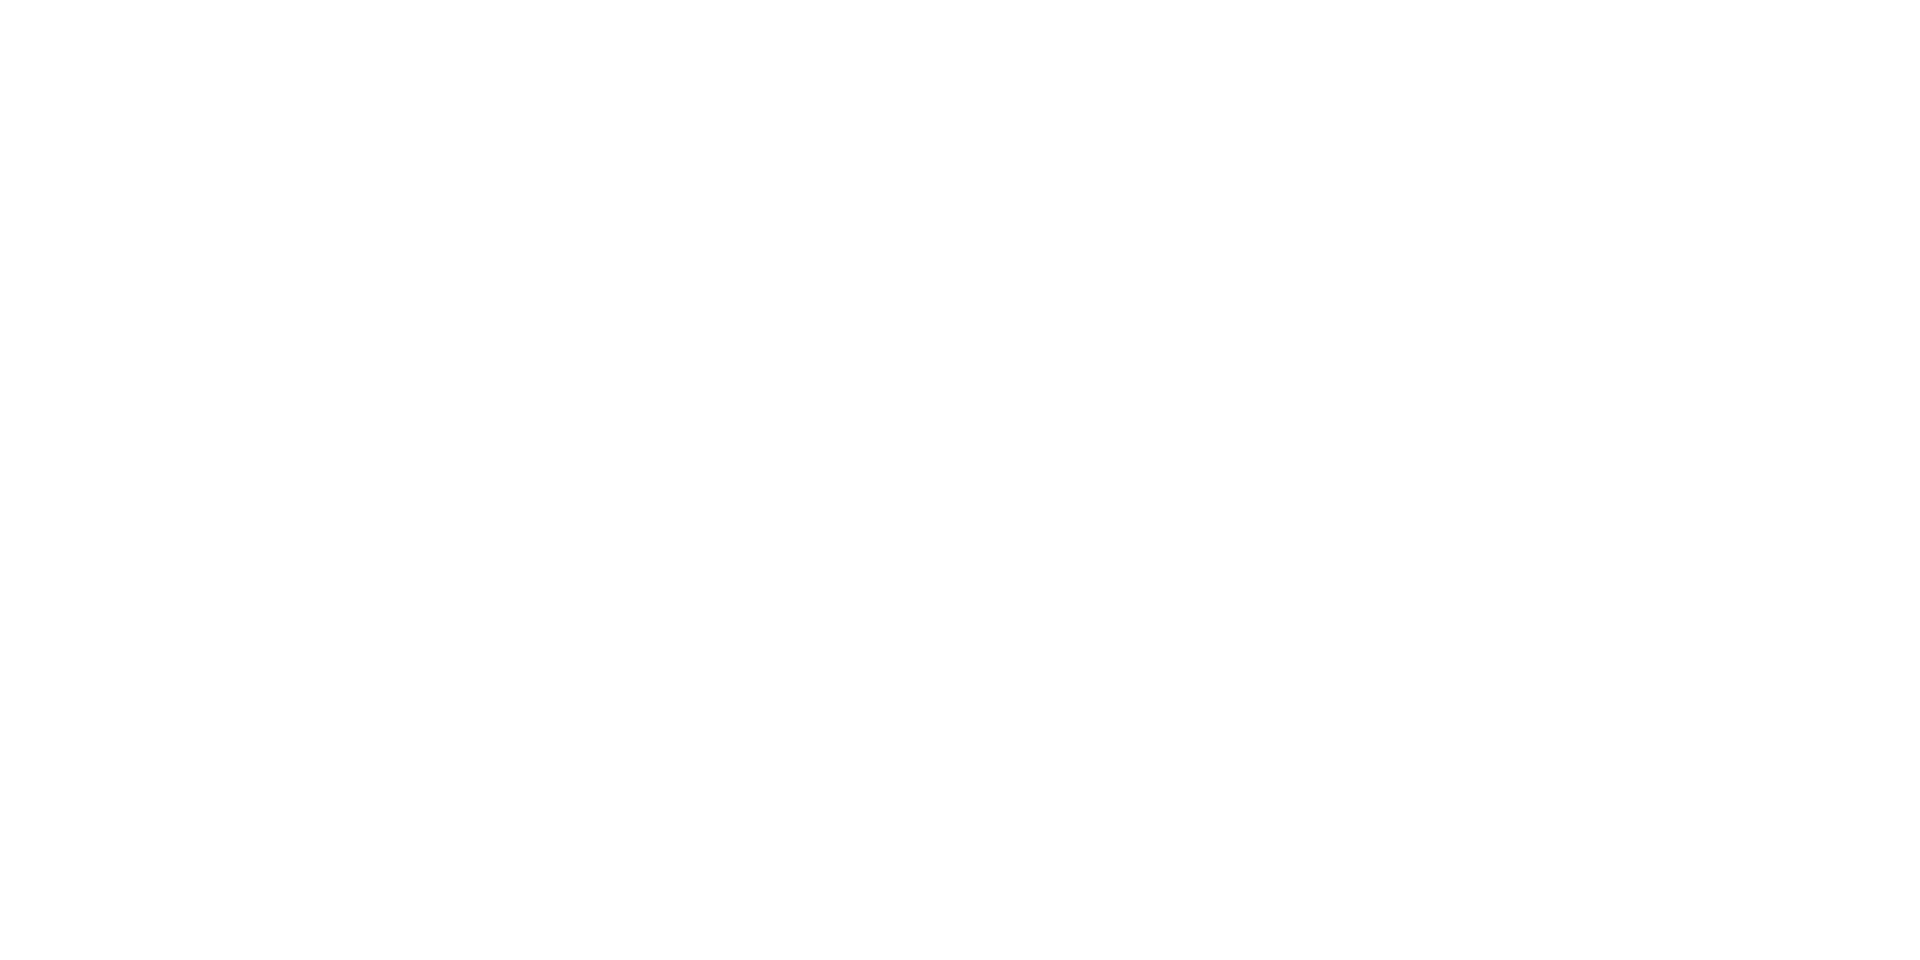

<IPython.core.display.Javascript object>


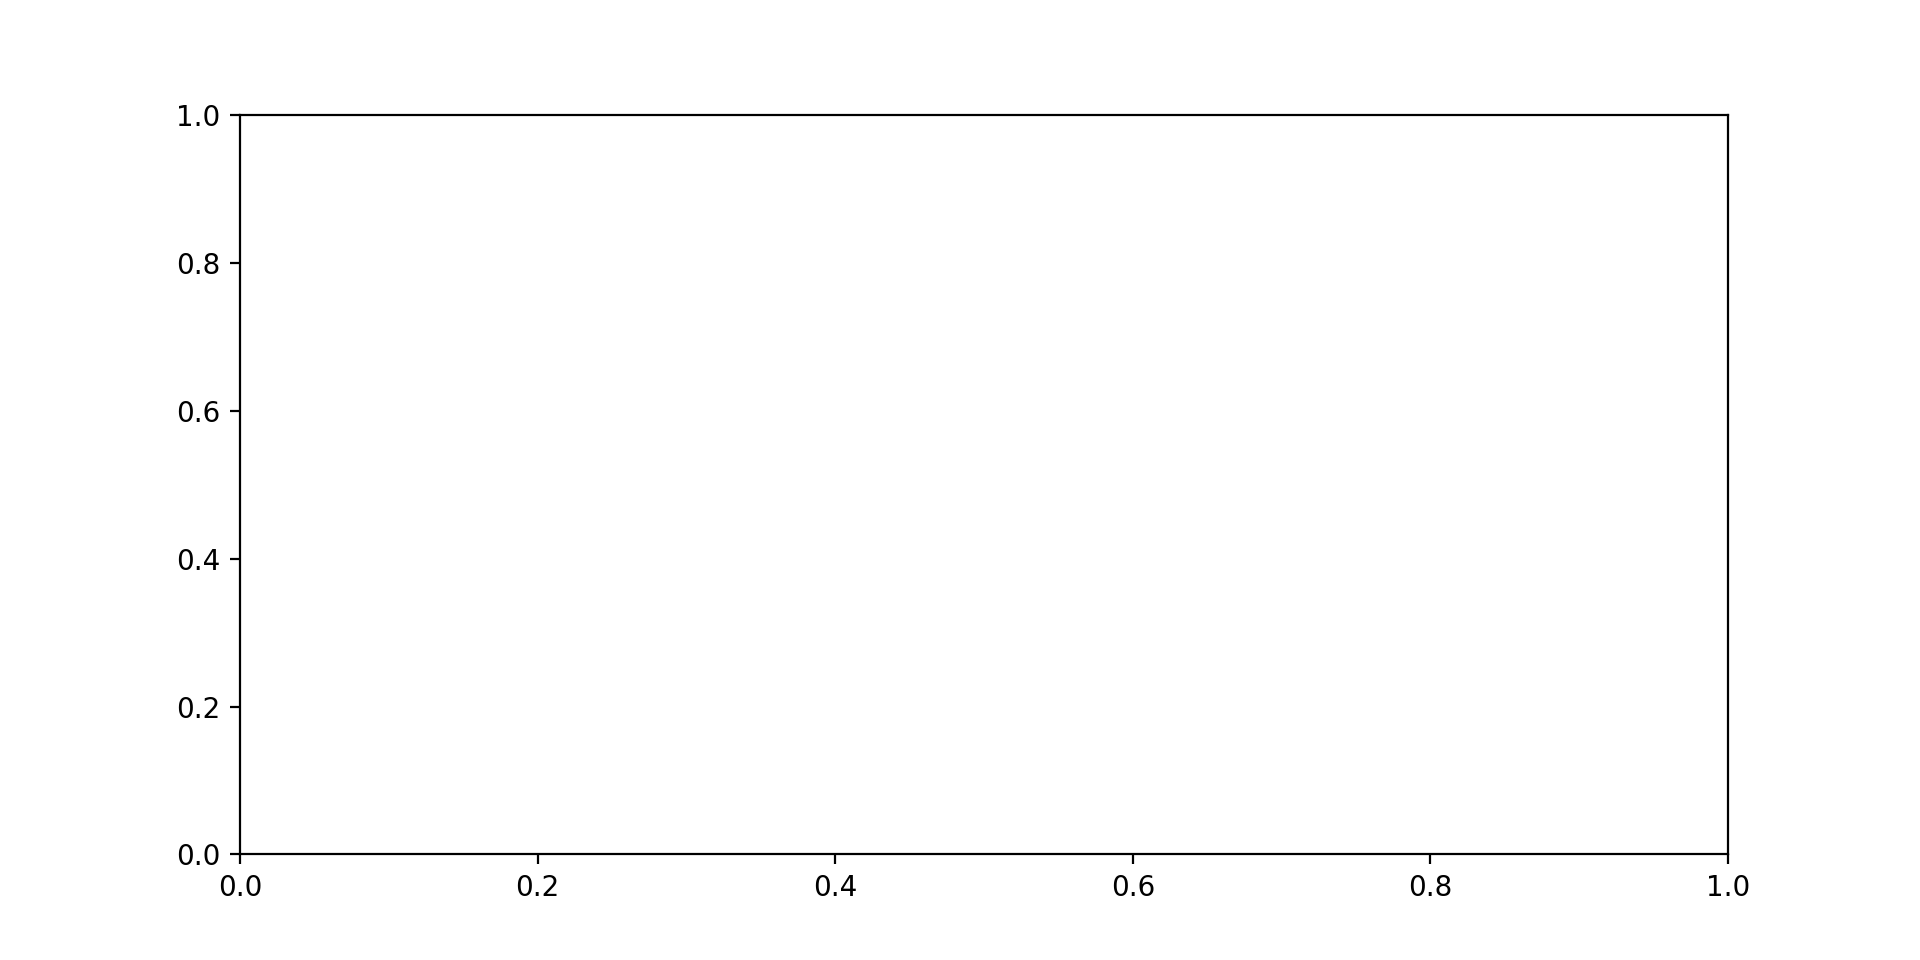

lander env att 2 fixed
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['means/bias:0', 'h3/kernel:0', 'logvars:0', 'h2/bias:0', 'h3/bias:0', 'h2/kernel:0', 'means/kernel:0', 'h1/kernel:0', 'h1/bias:0'])


In [3]:
from env_mdr import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)




obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "optimize_4km"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

# 9 square km

In [6]:
policy.test_mode=True
env.lander.divert=(0,0,0)
env.lander.apf_pot=env.lander.apf_pot2
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,3000 , -70, -10), 
                           crossrange = (-1500,1500 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=0*np.ones(3), noise_sd=0*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9766.26 |2701.78 |3200.00 |16000.00 |    94
glideslope | 3.028 | 8.272 | 0.515 |620.573 |    56
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.3     0.0    -0.0 |     0.5     0.5     0.0 |    -0.7    -2.7    -0.0 |     1.8     1.7    -0.0
velocity |   0.044  -0.034  -0.949 |   0.019   0.065   0.040 |  -0.027  -0.137  -1.028 |   0.098   0.121  -0.825
fuel     |301.74 | 22.40 |265.67 |361.48
attitude_321 |  -0.079  -0.025  -0.019 |   0.137   0.011   0.021 |  -0.413  -0.058  -0.054 |   0.214   0.012   0.051
w        |  -0.037  -0.016  -0.000 |   0.059   0.027   0.000 |  -0.175  -0.087  -0.000 |   0.078   0.052   0.000
glideslope |  22.057 |   7.661 |  10.838 |  43.266
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9694.90 |2698.42 |3200.00 |16000.00 |    94
glideslope | 3.246 | 9.159 | 0.515 |620.573 |    56
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9626.16 |2687.85 |3200.00 |16000.00 |    94
glideslope | 2.979 | 8.354 | 0.265 |1085.152 |   587
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.6    -3.4    -0.0 |     2.9     4.8    -0.0
velocity |   0.042  -0.031  -0.944 |   0.017   0.065   0.044 |  -0.027  -0.171  -1.060 |   0.100   0.185  -0.791
fuel     |306.39 | 23.93 |263.12 |392.67
attitude_321 |  -0.058  -0.025  -0.018 |   0.155   0.009   0.022 |  -0.464  -0.067  -0.078 |   0.495   0.031   0.051
w        |  -0.031  -0.009   0.000 |   0.054   0.027   0.000 |  -0.175  -0.167  -0.000 |   0.108   0.073   0.000
glideslope |  21.012 |  13.806 |   9.245 | 396.036
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9626.24 |2690.03 |3200.00 |16000.00 |    94
glideslope | 2.963 | 8.508 | 0.265 |1361.660 |  1275
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9640.50 |2699.22 |3200.00 |16000.00 |    94
glideslope | 2.972 | 9.189 | 0.265 |1938.933 |  1380
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.6    -3.4    -0.0 |     2.9     4.8    -0.0
velocity |   0.042  -0.030  -0.942 |   0.016   0.065   0.045 |  -0.027  -0.174  -1.065 |   0.121   0.185  -0.770
fuel     |306.84 | 23.96 |263.12 |392.67
attitude_321 |  -0.061  -0.025  -0.018 |   0.153   0.009   0.022 |  -0.464  -0.067  -0.078 |   0.512   0.031   0.051
w        |  -0.030  -0.009   0.000 |   0.053   0.026   0.000 |  -0.175  -0.167  -0.000 |   0.108   0.075   0.000
glideslope |  20.849 |  11.173 |   9.245 | 396.036
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |9640.83 |2698.04 |3200.00 |16000.00 |    94
glideslope | 2.973 | 9.223 | 0.265 |1938.933 |  1380
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9629.80 |2701.00 |3200.00 |16000.00 |    94
glideslope | 2.962 | 9.261 | 0.265 |2321.136 |  3299
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.8    -4.3    -0.0 |     5.0     4.8    -0.0
velocity |   0.042  -0.029  -0.942 |   0.016   0.065   0.045 |  -0.028  -0.174  -1.075 |   0.121   0.188  -0.716
fuel     |307.17 | 24.16 |263.10 |392.67
attitude_321 |  -0.063  -0.025  -0.019 |   0.151   0.009   0.022 |  -0.464  -0.071  -0.078 |   0.512   0.031   0.052
w        |  -0.029  -0.009   0.000 |   0.053   0.026   0.000 |  -0.175  -0.167  -0.000 |   0.111   0.079   0.000
glideslope |  20.683 |  10.232 |   8.704 | 396.036
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |9634.49 |2702.59 |3200.00 |16000.00 |    94
glideslope | 2.962 | 9.231 | 0.265 |2321.136 |  3299
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9638.28 |2698.55 |3200.00 |16000.00 |    94
glideslope | 3.011 | 9.677 | 0.265 |2321.136 |  3299
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.8    -4.3    -0.0 |     5.0     4.8    -0.0
velocity |   0.042  -0.029  -0.942 |   0.016   0.065   0.045 |  -0.028  -0.174  -1.075 |   0.121   0.188  -0.716
fuel     |306.74 | 24.07 |263.10 |392.67
attitude_321 |  -0.064  -0.025  -0.019 |   0.151   0.009   0.022 |  -0.464  -0.071  -0.082 |   0.512   0.031   0.052
w        |  -0.029  -0.009   0.000 |   0.053   0.026   0.000 |  -0.175  -0.167  -0.000 |   0.111   0.079   0.000
glideslope |  20.706 |   9.984 |   8.704 | 396.036
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |9637.14 |2698.05 |3200.00 |16000.00 |    94
glideslope | 3.008 | 9.665 | 0.265 |2321.136 |  3299
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9639.23 |2697.51 |3200.00 |16000.00 |    94
glideslope | 3.004 | 9.780 | 0.265 |2717.867 |  5165
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.8    -4.3    -0.0 |     5.0     4.8    -0.0
velocity |   0.042  -0.029  -0.942 |   0.016   0.065   0.045 |  -0.029  -0.174  -1.075 |   0.121   0.188  -0.716
fuel     |306.64 | 23.85 |263.10 |392.67
attitude_321 |  -0.064  -0.025  -0.019 |   0.151   0.009   0.021 |  -0.464  -0.071  -0.082 |   0.512   0.031   0.052
w        |  -0.029  -0.010   0.000 |   0.054   0.026   0.000 |  -0.184  -0.167  -0.000 |   0.111   0.079   0.000
glideslope |  20.798 |   9.685 |   8.704 | 396.036
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |9638.93 |2697.37 |3200.00 |16000.00 |    94
glideslope | 3.008 | 9.764 | 0.265 |2717.867 |  5165
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9635.16 |2695.60 |3200.00 |16000.00 |    94
glideslope | 2.983 |10.000 | 0.265 |3940.078 |  6441
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.8    -4.3    -0.0 |     5.0     4.8    -0.0
velocity |   0.042  -0.030  -0.941 |   0.016   0.065   0.045 |  -0.029  -0.174  -1.075 |   0.121   0.188  -0.696
fuel     |306.78 | 23.90 |263.10 |393.00
attitude_321 |  -0.065  -0.025  -0.019 |   0.151   0.009   0.022 |  -0.468  -0.071  -0.082 |   0.512   0.031   0.055
w        |  -0.029  -0.010   0.000 |   0.053   0.027   0.000 |  -0.184  -0.167  -0.000 |   0.130   0.079   0.000
glideslope |  20.849 |  12.794 |   8.704 | 722.243
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |9635.24 |2696.81 |3200.00 |16000.00 |    94
glideslope | 2.981 | 9.963 | 0.265 |3940.078 |  6441
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9636.71 |2697.19 |3200.00 |16000.00 |    94
glideslope | 2.973 |10.033 | 0.265 |3940.078 |  6441
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.8    -4.3    -0.0 |     5.0     4.8    -0.0
velocity |   0.042  -0.030  -0.941 |   0.016   0.065   0.045 |  -0.029  -0.174  -1.075 |   0.121   0.188  -0.630
fuel     |306.89 | 23.90 |262.94 |401.31
attitude_321 |  -0.064  -0.025  -0.019 |   0.151   0.009   0.021 |  -0.468  -0.076  -0.082 |   0.554   0.031   0.055
w        |  -0.030  -0.010   0.000 |   0.053   0.027   0.000 |  -0.186  -0.167  -0.000 |   0.130   0.079   0.000
glideslope |  20.805 |  12.259 |   8.704 | 722.243
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |9637.53 |2697.91 |3200.00 |16000.00 |    94
glideslope | 2.971 |10.029 | 0.265 |3940.078 |  6441
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9639.39 |2697.96 |3200.00 |16000.00 |    94
glideslope | 2.971 | 9.928 | 0.265 |3940.078 |  6441
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.8    -4.3    -0.0 |     5.0     4.8    -0.0
velocity |   0.042  -0.030  -0.942 |   0.016   0.065   0.045 |  -0.029  -0.183  -1.075 |   0.151   0.188  -0.630
fuel     |306.96 | 23.99 |262.94 |401.31
attitude_321 |  -0.063  -0.025  -0.019 |   0.151   0.009   0.021 |  -0.468  -0.076  -0.082 |   0.554   0.031   0.055
w        |  -0.030  -0.010   0.000 |   0.054   0.027   0.000 |  -0.186  -0.168  -0.000 |   0.130   0.079   0.000
glideslope |  20.801 |  12.183 |   8.704 | 722.243
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |9640.21 |2698.29 |3200.00 |16000.00 |    94
glideslope | 2.972 | 9.903 | 0.265 |3940.078 |  6441
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F


Cumulative Stats (mean,std,max,argmax)
thrust   |9640.53 |2697.04 |3200.00 |16000.00 |    94
glideslope | 2.975 | 9.923 | 0.265 |3940.078 |  6441
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     0.5     0.5     0.0 |    -1.8    -4.3    -0.0 |     5.0     4.8    -0.0
velocity |   0.042  -0.030  -0.942 |   0.016   0.065   0.045 |  -0.029  -0.183  -1.114 |   0.151   0.193  -0.630
fuel     |306.85 | 23.95 |262.94 |401.31
attitude_321 |  -0.063  -0.025  -0.019 |   0.151   0.009   0.021 |  -0.468  -0.076  -0.082 |   0.554   0.031   0.055
w        |  -0.030  -0.010   0.000 |   0.054   0.026   0.000 |  -0.186  -0.181  -0.000 |   0.130   0.080   0.000
glideslope |  20.773 |  11.880 |   8.704 | 722.243

Initial Stats (mean,std,min,max)
position |  1505.9    -0.6  2350.6 |   866.9   866.1    29.0 |     0.1 -1499.9  2300.0 |  3000.0  1499.7  2400.0
velocity | -40.140   0.004 -80.016 |  17.395  17.317   5.768 | -69.998 -2

# 12 sq km 3000m

In [36]:
policy.test_mode=True
env.lander.divert=(0,0,0)
env.lander.apf_pot=env.lander.apf_pot2
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,4000 , -70, -10), 
                           crossrange = (-1500,1500 , -30,30),  
                           altitude = (2900,3100,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=0*np.ones(3), noise_sd=0*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9137.82 |2346.19 |3200.00 |16000.00 |    82
glideslope | 2.962 | 8.911 | 0.587 |819.085 |    15
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5    -0.2    -0.0 |     0.6     0.4     0.0 |    -1.0    -1.3    -0.0 |     2.1     1.0    -0.0
velocity |   0.042  -0.038  -0.929 |   0.017   0.063   0.046 |  -0.019  -0.142  -1.017 |   0.074   0.141  -0.777
fuel     |334.84 | 26.90 |290.74 |405.12
attitude_321 |  -0.033  -0.023  -0.015 |   0.172   0.008   0.020 |  -0.487  -0.052  -0.046 |   0.343   0.001   0.039
w        |  -0.034  -0.008   0.000 |   0.048   0.023   0.000 |  -0.165  -0.073  -0.000 |   0.058   0.059   0.000
glideslope |  20.491 |   7.236 |  10.895 |  52.488
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9117.11 |2375.01 |3200.00 |16000.00 |    82
glideslope | 3.032 | 8.561 | 0.579 |819.085 |    15
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9160.89 |2384.17 |3200.00 |16000.00 |   412
glideslope | 2.996 | 8.454 | 0.436 |1532.022 |  1027
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    31.3    -9.0    36.2 |   328.0    99.4   322.5 |   -57.9 -1457.9    -0.1 |  3950.0   492.4  2976.3
velocity |  -0.387  -0.078  -1.885 |   4.607   1.869   8.527 | -66.570 -26.319 -88.209 |   0.114  29.085  -0.566
fuel     |332.61 | 46.55 |  3.34 |427.00
attitude_321 |  -0.018  -0.026  -0.027 |   0.185   0.135   0.129 |  -0.923  -1.390  -1.462 |   0.860   1.393   0.794
w        |  -0.038  -0.009  -0.000 |   0.052   0.064   0.000 |  -0.236  -0.930  -0.000 |   0.202   1.015   0.000
glideslope |  20.374 |   8.389 |   1.004 |  97.429
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9157.21 |2386.83 |3200.00 |16000.00 |   412
glideslope | 2.976 | 8.363 | 0.436 |1532.022 |  1027
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9162.52 |2400.19 |3200.00 |16000.00 |   412
glideslope | 2.981 | 8.740 | 0.436 |1764.253 |  2188
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    18.3    -5.2    22.8 |   250.8    78.6   256.7 |   -57.9 -1459.2    -0.1 |  3950.0   492.4  3006.9
velocity |  -0.238  -0.081  -1.523 |   3.764   1.493   6.729 | -66.723 -27.350 -88.209 |   0.114  29.085  -0.566
fuel     |335.44 | 41.47 |  3.34 |447.99
attitude_321 |  -0.017  -0.024  -0.022 |   0.177   0.109   0.099 |  -0.923  -1.390  -1.462 |   0.860   1.393   0.794
w        |  -0.039  -0.009  -0.000 |   0.051   0.050   0.000 |  -0.434  -0.930  -0.000 |   0.202   1.015   0.000
glideslope |  20.541 |   8.299 |   1.004 | 101.614
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |9160.23 |2402.03 |3200.00 |16000.00 |   412
glideslope | 2.975 | 8.658 | 0.436 |1764.253 |  2188
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9158.06 |2400.29 |3200.00 |16000.00 |   412
glideslope | 2.958 | 8.646 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    16.2    -4.1    21.3 |   234.3    72.7   248.3 |   -57.9 -1459.2    -0.1 |  3950.0   886.4  3006.9
velocity |  -0.233  -0.075  -1.490 |   3.797   1.511   6.570 | -66.723 -27.350 -88.209 |   0.127  29.085  -0.566
fuel     |335.48 | 40.74 |  3.21 |447.99
attitude_321 |  -0.016  -0.024  -0.022 |   0.178   0.108   0.093 |  -0.999  -1.391  -1.462 |   0.860   1.393   0.794
w        |  -0.040  -0.009  -0.000 |   0.051   0.049   0.000 |  -0.434  -0.930  -0.000 |   0.202   1.015   0.000
glideslope |  20.583 |   8.658 |   1.004 | 123.789
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |9159.23 |2399.11 |3200.00 |16000.00 |   412
glideslope | 2.970 | 8.607 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9157.65 |2397.88 |3200.00 |16000.00 |   412
glideslope | 2.947 | 8.516 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    16.2    -3.7    21.3 |   234.7    68.4   248.0 |   -57.9 -1459.2    -0.1 |  3950.0   886.4  3006.9
velocity |  -0.237  -0.072  -1.491 |   3.843   1.544   6.581 | -67.694 -28.065 -88.209 |   0.130  29.085  -0.369
fuel     |335.39 | 40.58 |  2.94 |447.99
attitude_321 |  -0.017  -0.024  -0.021 |   0.178   0.109   0.092 |  -1.723  -1.391  -1.462 |   0.860   1.409   1.104
w        |  -0.040  -0.008  -0.000 |   0.051   0.051   0.000 |  -0.434  -0.930  -0.000 |   0.206   1.220   0.000
glideslope |  20.454 |   8.427 |   1.004 | 123.789
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |9157.99 |2397.92 |3200.00 |16000.00 |   412
glideslope | 2.945 | 8.480 | 0.436 |1800.766 |  3263
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9155.39 |2402.85 |3200.00 |16000.00 |   412
glideslope | 2.927 |10.705 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    14.7    -3.3    19.7 |   222.8    66.6   239.0 |   -57.9 -1459.2    -0.1 |  3950.0   886.4  3006.9
velocity |  -0.219  -0.073  -1.449 |   3.721   1.466   6.343 | -67.694 -28.065 -88.209 |   0.130  29.085  -0.369
fuel     |335.80 | 39.90 |  2.94 |447.99
attitude_321 |  -0.017  -0.024  -0.021 |   0.178   0.105   0.089 |  -1.723  -1.394  -1.462 |   0.860   1.409   1.104
w        |  -0.040  -0.008   0.000 |   0.051   0.048   0.000 |  -0.548  -0.930  -0.000 |   0.303   1.220   0.000
glideslope |  20.418 |   8.364 |   1.004 | 134.541
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |9154.38 |2403.06 |3200.00 |16000.00 |   412
glideslope | 2.922 |10.664 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9155.46 |2402.78 |3200.00 |16000.00 |   412
glideslope | 2.925 |10.371 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    13.7    -1.9    20.4 |   214.5    71.2   243.0 |   -57.9 -1459.2    -0.1 |  3950.0  1457.3  3006.9
velocity |  -0.244  -0.065  -1.464 |   3.921   1.566   6.414 | -67.694 -28.065 -88.209 |   0.141  30.830  -0.369
fuel     |335.80 | 40.24 |  2.55 |447.99
attitude_321 |  -0.017  -0.023  -0.021 |   0.179   0.107   0.091 |  -1.723  -1.394  -1.462 |   1.192   1.409   1.423
w        |  -0.039  -0.008   0.000 |   0.054   0.049   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.415 |   8.541 |   1.004 | 151.008
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |9155.12 |2402.47 |3200.00 |16000.00 |   412
glideslope | 2.931 |10.502 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9153.56 |2402.51 |3200.00 |16000.00 |   412
glideslope | 2.917 |10.179 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    13.8    -1.9    20.9 |   215.1    69.5   246.0 |   -57.9 -1459.2    -0.1 |  3978.0  1457.3  3006.9
velocity |  -0.250  -0.058  -1.474 |   3.961   1.569   6.461 | -67.694 -28.065 -88.209 |   0.157  30.830  -0.369
fuel     |335.76 | 40.42 |  2.55 |447.99
attitude_321 |  -0.017  -0.023  -0.021 |   0.180   0.107   0.094 |  -1.723  -1.394  -1.462 |   1.192   1.409   1.423
w        |  -0.039  -0.008   0.000 |   0.054   0.051   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.413 |   8.480 |   1.004 | 151.008
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |9153.74 |2402.86 |3200.00 |16000.00 |   412
glideslope | 2.920 |10.194 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9150.10 |2401.91 |3200.00 |16000.00 |   412
glideslope | 2.914 |10.014 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    14.1    -1.8    20.6 |   217.8    69.6   244.0 |   -57.9 -1459.2    -0.1 |  3978.0  1457.3  3006.9
velocity |  -0.242  -0.057  -1.465 |   3.900   1.595   6.405 | -67.694 -28.065 -88.209 |   0.157  30.830  -0.369
fuel     |335.89 | 40.31 |  2.55 |447.99
attitude_321 |  -0.017  -0.023  -0.020 |   0.180   0.105   0.093 |  -1.723  -1.414  -1.462 |   1.192   1.409   1.423
w        |  -0.040  -0.008   0.000 |   0.053   0.050   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.364 |   8.423 |   1.004 | 151.008
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |9150.65 |2402.20 |3200.00 |16000.00 |   412
glideslope | 2.913 | 9.988 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F


Cumulative Stats (mean,std,max,argmax)
thrust   |9150.43 |2400.19 |3200.00 |16000.00 |   412
glideslope | 2.912 | 9.872 | 0.436 |9427.474 |  5136
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    13.5    -1.8    20.1 |   212.5    68.1   241.1 |   -57.9 -1459.2    -0.1 |  3978.0  1457.3  3006.9
velocity |  -0.238  -0.062  -1.452 |   3.897   1.563   6.326 | -67.833 -28.065 -88.209 |   0.157  30.830  -0.369
fuel     |335.81 | 40.08 |  2.52 |447.99
attitude_321 |  -0.016  -0.023  -0.021 |   0.179   0.105   0.092 |  -1.723  -1.414  -1.493 |   1.192   1.409   1.423
w        |  -0.040  -0.008   0.000 |   0.053   0.050   0.000 |  -0.548  -0.930  -0.000 |   1.107   1.220   0.000
glideslope |  20.343 |   8.306 |   1.004 | 151.008

Initial Stats (mean,std,min,max)
position |  2009.8    12.5  2999.8 |  1155.9   863.2    58.0 |     0.1 -1499.8  2900.1 |  3999.4  1499.9  3099.9
velocity | -40.189  -0.024 -79.936 |  17.355  17.299   5.789 | -69.999 -2